| Размер матрицы   | Результат   |   Время на CPU, мсек |   Время на GPU, мсек |
|:-----------------|:------------|---------------------:|---------------------:|
| (320, 320)       | True        |            0.0212005 |            0.0599507 |
| (576, 576)       | True        |            0.115599  |            0.0980005 |
| (832, 832)       | True        |            0.3582    |            0.173     |
| (1088, 1088)     | True        |            0.8388    |            0.224601  |
| (1344, 1344)     | True        |            1.8532    |            0.382599  |
| (1600, 1600)     | True        |            4.85556   |            0.697399  |
| (1856, 1856)     | True        |           15.5804    |            1.3418    |
| (2112, 2112)     | True        |           30.5273    |            2.07173   |


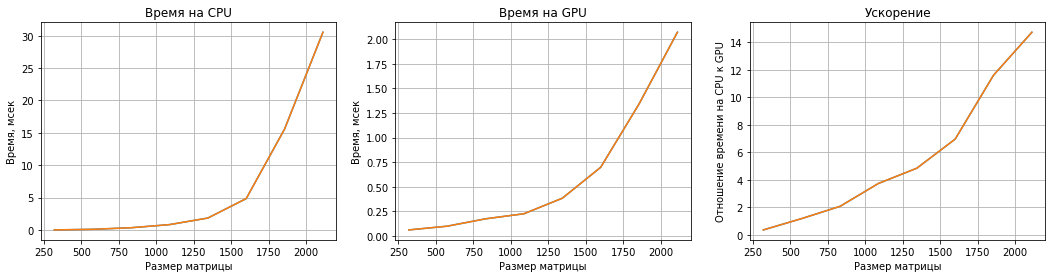

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time
from numba import cuda, int32
from tabulate import tabulate

TPB = 32

@cuda.jit

def gpu_calc(A, B, C):

    shr1 = cuda.shared.array(shape=(TPB, TPB), dtype=int32)
    shr2 = cuda.shared.array(shape=(TPB, TPB), dtype=int32)
    x, y = cuda.grid(2)
    thr_x = cuda.threadIdx.x
    thr_y = cuda.threadIdx.y
    res = 0.

    for i in range(cuda.gridDim.x):
        shr1[thr_x,  thr_y] = A[x,  thr_y + i * TPB]
        shr2[thr_x,  thr_y] = B[thr_x + i * TPB, y]
        cuda.syncthreads()

        for j in range(TPB):
            res += shr1[thr_x, j] * shr2[j,  thr_y]
        
        cuda.syncthreads()

    C[x, y] = res

rows = []

for i in range(10, 74, 8):

    cpu_ts = 0
    gpu_ts = 0

    grid_size = (i, i)
    block_size = (TPB, TPB)
    mat_size = (i * TPB, i * TPB)
    correct_result = True
    for m in range(5):
        a = np.random.randint(500, size=mat_size)
        b = np.random.randint(500, size=mat_size)
        c = np.zeros(mat_size, dtype=np.int32)

        start = time.time()
        cpu_calc = a.dot(b)
        cpu_t = time.time() - start
        cpu_ts += cpu_t
                
        start = time.time()
        A = cuda.to_device(a)
        B = cuda.to_device(b)
        C = cuda.to_device(c)
        gpu_calc[grid_size, block_size](A, B, C)
        c = C.copy_to_host()
        gpu_t = time.time() - start
        gpu_ts += gpu_t
                
        correct_result = np.array_equal(c, cpu_calc)

    row = [mat_size, correct_result, cpu_ts/5, gpu_ts/5]
    rows.append(row)

print(tabulate(rows, headers=['Размер матрицы', 'Результат', 'Время на CPU, мсек', 'Время на GPU, мсек'], tablefmt='pipe'))

matrix = list(map(lambda x: x[0], rows))
cpu = list(map(lambda x: x[2], rows))
gpu = list(map(lambda x: x[3], rows))
acc = list(map(lambda x: x[2] / x[3], rows))

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.title("Время на CPU")
plt.plot(matrix, cpu)
plt.xlabel("Размер матрицы")
plt.ylabel("Время, мсек")
plt.grid()

plt.subplot(1, 3, 2)
plt.title("Время на GPU")
plt.plot(matrix, gpu)
plt.xlabel("Размер матрицы")
plt.ylabel("Время, мсек")
plt.grid()

plt.subplot(1, 3, 3)
plt.title("Ускорение")
plt.plot(matrix, acc)
plt.xlabel("Размер матрицы")
plt.ylabel("Отношение времени на CPU к GPU")
plt.grid()

plt.show()